# Programming Exercise 3
# Multi-class Classification

## Introduction
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize handwritten digits.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat


import util3

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Submission and Grading


After completing each part of the assignment, be sure to submit your solutions to the grader. The following is a breakdown of how each part of this exercise is scored.


| Section | Part                                 | Submission function                   |  Points 
| :-      |:-                                    | :-                                    |  :-:    
| 1       | [Regularized Logistic Regression](#section1)     | [`lrCostFunction`](#lrCostFunction)   | 30     
| 2       | [One-vs-all classifier training](#section2)       | [`oneVsAll`](#oneVsAll)               | 20     
| 3       | [One-vs-all classifier prediction](#section3)     | [`predictOneVsAll`](#predictOneVsAll) | 20     
| 4       | [Neural Network Prediction Function](#section4)   | [`predict`](#predict)           | 30
|         | Total Points                         |                                 | 100    



## 1 Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you have learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset). The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. We use the `.mat` format here because this is the dataset provided in the MATLAB version of this assignment. Fortunately, python provides mechanisms to load MATLAB native format using the `loadmat` function within the `scipy.io` module. This function returns a python dictionary with keys containing the variable names within the `.mat` file. 

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
We start the exercise by first loading the dataset. Execute the cell below, you do not need to write any code here.

In [2]:
# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10

#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

m = y.size
print(m)

5000


### 1.2 Visualizing the data

You will begin by visualizing a subset of the training set. In the following cell, the code randomly selects selects 100 rows from `X` and passes those rows to the `displayData` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the `displayData` function in the file `utils.py`. You are encouraged to examine the code to see how it works. Run the following cell to visualize the data.

[2428 1863 1217 2990 3943  634 2923 4979  507 3269 4957 4988 2506 2385
 1833 4224   43 1333 2081 1033 1847  161 1097 3107  574 3202 4040 1804
 2680 2267  317 3022 4380  980 4871  513 4194 1160 4940 1305 4785 3417
 1004  683 1611 4142 4905 2666  663 1958 4359  759 4210 3008 2971 4593
 1869 4138 3835  396  416 2851 3183 3933 1485 1621 2625 2755 3523 4972
 3632 2732 2981  233 2235 2970   33 3496 2517 3176 2929 4175  758 2200
 4248 2186  742 3088 4192 1076 3307 2599  833  927 2543 3796  631 2734
 3334  476]
[4 3 2 5 7 1 5 9 1 6 9 9 5 4 3 8 0 2 4 2 3 0 2 6 1 6 8 3 5 4 0 6 8 1 9 1 8
 2 9 2 9 6 2 1 3 8 9 5 1 3 8 1 8 6 5 9 3 8 7 0 0 5 6 7 2 3 5 5 7 9 7 5 5 0
 4 5 0 6 5 6 5 8 1 4 8 4 1 6 8 2 6 5 1 1 5 7 1 5 6 0]


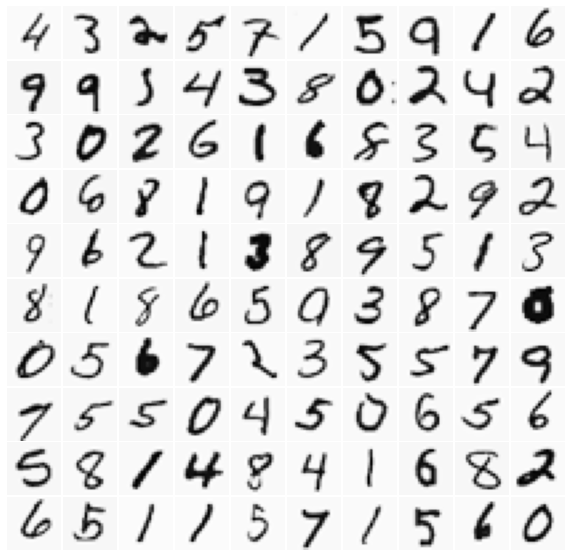

In [76]:
# Randomly select 100 data points to display


rand_indices = np.random.choice(m, 100, replace=False)
print(rand_indices)
sel = X[rand_indices, :]

util3.displayData(sel)

print( y[rand_indices] )

### 1.3 Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. You can use your code in the previous exercise as a starting point for this exercise. 

To test your vectorized logistic regression, we will use custom data as defined in the following cell.

In [31]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

<a id="section1"></a>
#### 1.3.1 Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

#### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. 

Your job is to write the unregularized cost function `lrCostFunction` which returns both the cost function $J(\theta)$ and its gradient $\frac{\partial J}{\partial \theta}$. Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

<div class="alert alert-box alert-warning">
**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` property of `numpy` arrays. For example, given a data matrix $X$ of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with size $20$, you can observe that `np.dot(X, theta)` is a valid multiplication operation, while `np.dot(theta, X)` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.
</div>
<a id="lrCostFunction"></a>

In [8]:
def sigmoid(z):
    z = np.array(z)
    g =  1 / (1 + np.exp(-z))
    return g

def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    """
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # Initialize some useful values
    m, n = X.shape
    # print(f" m : {m}, n {n}")
    
    H = sigmoid (np.dot(X, theta))
 
    # cost
    J =  (-1/m) * np.sum ( y * np.log(H) + (1- y) * np.log(1-H) ) +  (lambda_ /(2*m) ) * np.sum(theta[1:]**2)

    gradient = np.zeros(n)
    
    error = np.subtract(H, y)
    
    gradient_in = (1/m) * np.dot( error, X ) 
    
    # print(f"gradient shape: {gradient.shape}, gradient_in shape: {gradient_in.shape} ")
    

    gradient[0] = gradient_in[0] # theta(0)
    gradient[1:] = gradient_in[1:] + ( lambda_ / m * theta[1:] ) # theta(j) ; j>0
    
    # grad = np.append( gradient[0],  gradient[1:] )
    grad = gradient.flatten()
    
    # =============================================================
    return J, grad

#### 1.3.3 Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now
add regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not be regularizing $\theta_0$ which is used for the bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

Now modify your code in lrCostFunction in the [**previous cell**](#lrCostFunction) to account for regularization. Once again, you should not put any loops into your code.

<div class="alert alert-box alert-warning">
**python/numpy Tip:** When implementing the vectorization for regularized logistic regression, you might often want to only sum and update certain elements of $\theta$. In `numpy`, you can index into the matrices to access and update only certain elements. For example, A[:, 3:5]
= B[:, 1:3] will replaces the columns with index 3 to 5 of A with the columns with index 1 to 3 from B. To select columns (or rows) until the end of the matrix, you can leave the right hand side of the colon blank. For example, A[:, 2:] will only return elements from the $3^{rd}$ to last columns of $A$. If you leave the left hand size of the colon blank, you will select elements from the beginning of the matrix. For example, A[:, :2] selects the first two columns, and is equivalent to A[:, 0:2]. In addition, you can use negative indices to index arrays from the end. Thus, A[:, :-1] selects all columns of A except the last column, and A[:, -5:] selects the $5^{th}$ column from the end to the last column. Thus, you could use this together with the sum and power ($^{**}$) operations to compute the sum of only the elements you are interested in (e.g., `np.sum(z[1:]**2)`). In the starter code, `lrCostFunction`, we have also provided hints on yet another possible method computing the regularized gradient.
</div>

Once you finished your implementation, you can call the function `lrCostFunction` to test your solution using the following cell:

In [36]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


<a id="section2"></a>
### 1.4 One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$. 

You should now complete the code for the function `oneVsAll` below, to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\theta \in \mathbb{R}^{K \times (N +1)}$, where each row of $\theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a “for”-loop from $0$ to $K-1$, training each classifier independently.

Note that the `y` argument to this function is a vector of labels from 0 to 9. When training the classifier for class $k \in \{0, ..., K-1\}$, you will want a K-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j^{th}$ training instance belongs to class $k$ $(y_j = 1)$, or if it belongs to a different
class $(y_j = 0)$. You may find logical arrays helpful for this task. 

Furthermore, you will be using scipy's `optimize.minimize` for this exercise. 
<a id="oneVsAll"></a>

In [6]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop (`for c in range(num_labels):`) to loop over the different classes.
    
    """
    # Some useful variables
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    initial_theta = np.zeros(n + 1)

    # Set regularization parameter lambda to 1 (you should vary this)
    # lambda_ = 1

    # set options for optimize.minimize
    options= {'maxiter': 50}

    for c in range(num_labels):
        res = optimize.minimize(lrCostFunction,
                            initial_theta,
                            (X, (y == c), lambda_),
                            jac=True,
                            method='CG',
                            options=options)
        # the optimized theta is in the x property of the result
        all_theta[c] = res.x   


    # ============================================================
    return all_theta

After you have completed the code for `oneVsAll`, the following cell will use your implementation to train a multi-class classifier. 

In [92]:
lambda_ = 0.1
num_labels = 10
all_theta = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

# print(all_theta)

(10, 401)


<a id="section3"></a>
#### 1.4.1 One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example. You should now complete the code in the function `predictOneVsAll` to use the one-vs-all classifier for making predictions. 
<a id="predictOneVsAll"></a>

In [54]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    """
    m , n = X.shape
    num_labels = all_theta.shape[0]
    
    Y = np.zeros((m, num_labels))
    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # ====================== YOUR CODE HERE ======================
    for i  in range(num_labels):
        H = sigmoid (np.dot(X, all_theta[i]) )
        Y[ :,i] = H
    
    max_indices = np.argmax(Y, axis=1)
    
    p = max_indices
    # ============================================================
    return p

Once you are done, call your `predictOneVsAll` function using the learned value of $\theta$. You should see that the training set accuracy is about 95.1% (i.e., it classifies 95.1% of the examples in the training set correctly).

In [55]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.16%


 predict is  [6]
 random 3109  is 6 


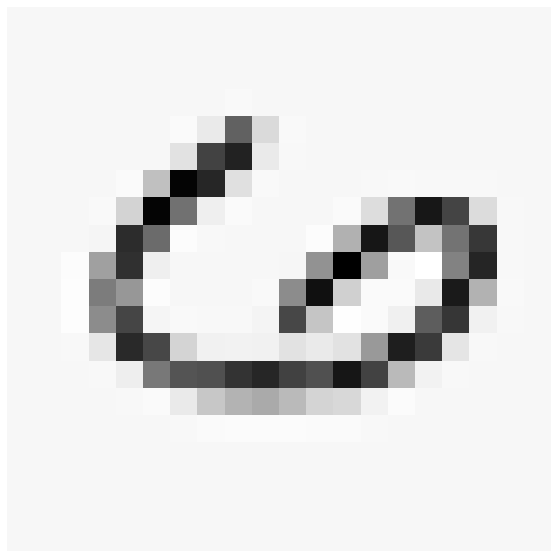

In [80]:
## Verify prediction

rand_ind = np.random.randint(0, 5000 )
util3.displayData( X[rand_ind])

predict = X[rand_ind][np.newaxis, :]

print( f" predict is  {predictOneVsAll(all_theta,  predict ) }" )
print(f" random {rand_ind}  is { y[rand_ind] } ")

In [81]:
## using sciklean
from sklearn.linear_model import LogisticRegression # for classification

model =LogisticRegression(max_iter=5000)
model.fit(X, y)


LogisticRegression(max_iter=5000)

 predict is  [3]
 random 1933  is 3 


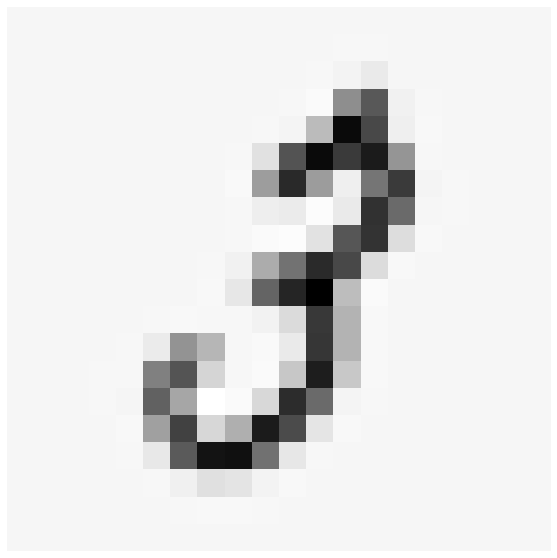

In [89]:
rand_ind = np.random.randint(0, 5000 )
util3.displayData( X[rand_ind])

predict_X = X[rand_ind][np.newaxis, :]
pred = model.predict(predict_X)

print( f" predict is  {pred }" )
print(f" random {rand_ind}  is { y[rand_ind] } ")
